# EBLR

In [1]:
from lineartree import LinearBoostClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
from joblib import dump
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [2]:
import sys
sys.path.append('F:\\Users\\Manuel García Plaza\\Desktop\\TFG\\')

In [3]:
from notebooks.utils.classification_metrics import classification

In [4]:
train =  pd.read_parquet('../../../data/model_input/train_sets/software_defect.parquet')
validation =  pd.read_parquet('../../../data/model_input/validation_sets/software_defect.parquet')

y_train = train.defects
X_train = train.drop(columns=['defects'])

y_validation = validation.defects
X_validation = validation.drop(columns=['defects'])

In [5]:
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

In [6]:
max_depth = [1, 2, 3]
n_est = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
base_est =  [LogisticRegression(penalty=None), LogisticRegression(), LogisticRegression(penalty='l1', solver='liblinear')]

In [7]:
names_list = []
for n in n_est:
    for depth in max_depth:
        for est in base_est:
            if est.penalty == None:
                name = f'EBLR_{depth}_{n}'
            elif est.penalty == 'l2':
                name = f'EBLR_{depth}_{n}_l2'
            elif est.penalty == 'l1':
                name = f'EBLR_{depth}_{n}_l1'
            elif est.penalty == 'elasticnet':
                name = f'EBLR_{depth}_{n}_en_{est.l1_ratio}'
            else:
                raise ValueError('Unknown base estimator type')

            names_list.append(name)

In [8]:
models_list = []
for n in n_est:
    for i in max_depth:
        for est in base_est:
            models_list.append(LinearBoostClassifier(base_estimator=est, n_estimators=n, max_depth=i))

In [9]:
metrics = classification(models_list, names_list, '../../../data/metrics/software_defect/eblr.csv', X_train_scaled, y_train, X_validation_scaled, y_validation, metrics={})
metrics

,Run_Time,Train_AUC,Validation_AUC,delta%
EBLR_1_1,0.753139,0.779970,0.780168,0.025369
EBLR_1_1_l2,0.729077,0.779971,0.780169,0.025440
EBLR_1_1_l1,2.828788,0.779961,0.780159,0.025343
EBLR_2_1,0.803822,0.780094,0.780128,0.004317
EBLR_2_1_l2,0.773941,0.780098,0.780135,0.004760
...,...,...,...,...
EBLR_2_10_l2,5.243751,0.779488,0.779352,-0.017482
EBLR_2_10_l1,48.587924,0.779483,0.779365,-0.015173
EBLR_3_10,5.439739,0.779277,0.779034,-0.031178
EBLR_3_10_l2,5.346857,0.779275,0.779030,-0.031472


In [11]:
metrics.sort_values(by='Validation_AUC', ascending=False).head(15)

,Run_Time,Train_AUC,Validation_AUC,delta%
EBLR_1_2,1.091483,0.780044,0.780413,0.047348
EBLR_1_4,2.198428,0.780049,0.780411,0.046435
EBLR_1_2_l2,1.156334,0.780042,0.780409,0.047117
EBLR_1_9_l2,3.964710,0.780045,0.780402,0.045790
EBLR_1_8_l1,50.977870,0.780042,0.780402,0.046148
EBLR_1_7_l1,44.114661,0.780041,0.780402,0.046213
EBLR_1_6_l1,39.709700,0.780041,0.780401,0.046138
EBLR_1_9_l1,39.995935,0.780041,0.780401,0.046183
EBLR_1_10_l1,69.960958,0.780042,0.780401,0.046057
EBLR_1_9,3.898711,0.780044,0.780401,0.045841


We choose **EBLR_1_2** because is the simplest model and achieves the best AUC

In [12]:
test =  pd.read_parquet('../../../data/model_input/test_sets/software_defect.parquet')

y_test = test.defects
X_test = test.drop(columns=['defects'])

In [13]:
retrain = pd.concat([train, validation])

y_retrain = retrain.defects
X_retrain = retrain.drop(columns=['defects'])

In [14]:
scaler_retrain = StandardScaler().fit(X_retrain)

X_retrain_scaled = scaler_retrain.transform(X_retrain)
X_test_scaled = scaler_retrain.transform(X_test)

In [25]:
model = LinearBoostClassifier(base_estimator=LogisticRegression(penalty=None), n_estimators=2, max_depth=1).fit(X_retrain_scaled, y_retrain)

In [26]:
test_pred = model.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, test_pred)
print('Test AUC:', round(auc, 4))

Test AUC: 0.7849


In [27]:
dump(model, 'best_eblr.joblib')

['best_eblr.joblib']

In [28]:
with open('../../../data/metrics/software_defect/final_AUC.txt', 'a') as f:
    f.write('\nEBLR, '+ str(auc))

In [29]:
print(f'Initial number of features: {X_retrain.shape[1]}\nFinal number of features: {model.transform(X_retrain_scaled).shape[1]}')

Initial number of features: 21
Final number of features: 23


In [30]:
error_trees = model._trees

#### New Feature 1

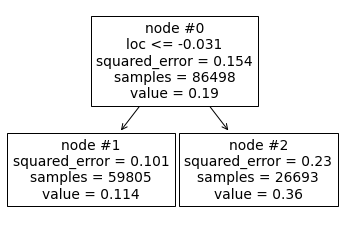

In [31]:
plot_tree(error_trees[0], node_ids=True, feature_names=X_retrain.columns);

In [32]:
pred = np.abs(error_trees[0].predict(X_retrain_scaled))
worst_leaf = np.argmax(pred)
error_path = error_trees[0].decision_path(X_retrain_scaled[[worst_leaf]]).toarray()
indexes = np.where(error_path == 1)[1]

path1 = []
for i in indexes[:-1]:
    path1.append(str(X_retrain.columns[error_trees[0].tree_.feature[i]])+' <= '+str(error_trees[0].tree_.threshold[i]))
path1.append('leaf value: '+str(model._leaves[0]))

path1

['loc <= -0.03147734422236681', 'leaf value: 0.3601318697785936']

If $loc > -0.03147734422236681$, then this feature generates a 1

In [33]:
pred_tree = np.abs(error_trees[0].predict(X_retrain_scaled.astype(np.float32), check_input=False))
pred_tree = (pred_tree == model._leaves[0]).astype(np.float32)
pred_tree = pred_tree.reshape(-1, 1)
X_trans = np.concatenate([X_retrain_scaled, pred_tree], axis=1)

#### New Feature 2

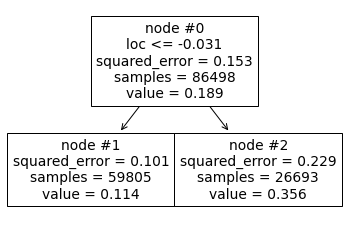

In [34]:
plot_tree(error_trees[1], node_ids=True, feature_names=list(X_retrain.columns)+['New_Feature_1']);

In [35]:
pred = np.abs(error_trees[1].predict(X_trans))
worst_leaf = np.argmax(pred)
error_path = error_trees[1].decision_path(X_trans[[worst_leaf]]).toarray()
indexes = np.where(error_path == 1)[1]

path2 = []
for i in indexes[:-1]:
    path2.append(str(list(list(X_retrain.columns)+['New_Feature_1'])[error_trees[1].tree_.feature[i]])+' <= '+str(error_trees[1].tree_.threshold[i]))
path2.append('leaf value: '+str(model._leaves[1]))

path2

['loc <= -0.03147734422236681', 'leaf value: 0.3555988461394373']

It is the same as before

In [36]:
top_threshold = 0
top_coefficients = [coef for coef in model.base_estimator_.coef_.ravel() if abs(coef) > top_threshold]
top_features = [name for name, coef in zip(X_retrain.columns, model.base_estimator_.coef_.ravel()) if abs(coef) > top_threshold]
labels = [' ' if feature not in top_features else feature for feature in X_retrain.columns]+['New_Feature_1']+['New_Feature_2']

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_9844/893457555.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=50, ha='right')


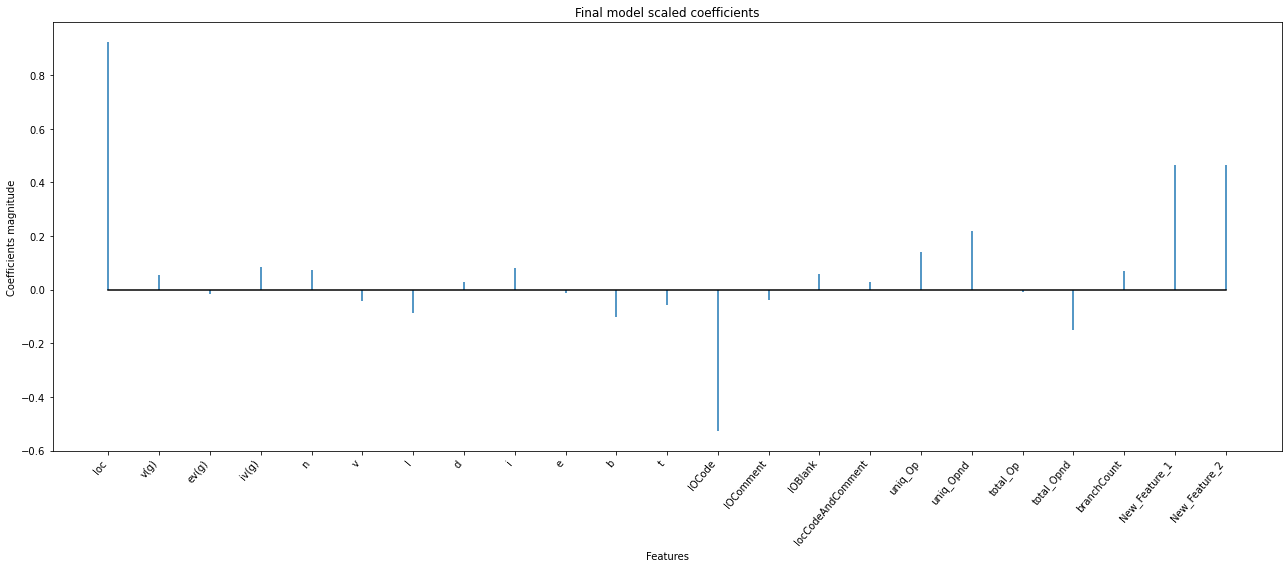

In [38]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.stem(list(list(X_retrain.columns)+['New_Feature_1']+['New_Feature_2']), model.base_estimator_.coef_.ravel(), markerfmt=' ', basefmt='k-')
ax.set_xlabel('Features')
ax.set_ylabel('Coefficients magnitude')
ax.set_title('Final model scaled coefficients')
ax.set_xticklabels(labels, rotation=50, ha='right')
plt.tight_layout()
plt.show()